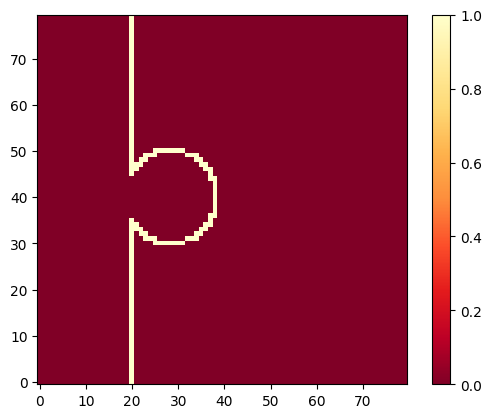

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt

nx = 80
ny = 80
L = ny // 4

r = L/2
d = 0.85 # set this between 0 and 1

x0 = np.arange(0, nx)
y0 = np.zeros((ny))
ymax = np.ones((ny))*ny


angle = np.linspace( -np.pi/2 , 3*np.pi/2 , 200 )
x = r * np.cos( angle ) + nx // 2
y = r * np.sin( angle ) + L + r*d

for y_ in y:
    if y_ < L:
        place = np.where(y == y_)
        y = np.delete(y, place)
        x = np.delete(x, place)


# plots the blood vessel adjacent to the aneurysm
x2 = int(np.around(x[0], decimals = 0))
x1 = int(np.around(x[-1], decimals = 0))

x = np.append(x, np.arange(x1, -1, -1))
y = np.append(y, np.ones(np.shape(np.arange(x1, -1, -1)))*L)

x = np.flip(x)
y = np.flip(y)

x = np.append(x, np.arange(x2, nx))
y = np.append(y, np.ones(np.shape(np.arange(x2, nx)))*L)


x1 = np.around(x, decimals = 0).astype(int)
y1 = np.around(y, decimals = 0).astype(int)

x2 = np.copy(x1)
y2 = np.copy(y1)

for i in range(0, nx):
    for j in range(0, ny):
        num = (i - nx // 2)**2 + (j - L - r*d)**2
        if num <= r**2 or j < L:
            x2 = np.append(x2, i)
            y2 = np.append(y2, j)

mask = np.zeros((nx, ny))
inner_mask = np.zeros((nx, ny))
points = np.column_stack((x1, y1))
points = np.unique(points, axis = 0)
inner_points = np.column_stack((x2, y2))
inner_points = np.unique(inner_points, axis = 0)

for i in points:
    mask[i[0], i[1]] = 1
for i in inner_points:
    inner_mask[i[0], i[1]] = 1

# mask = np.transpose(mask)
# inner_mask = np.transpose(inner_mask)
plt.set_cmap('YlOrRd_r')
plt.imshow(mask, origin='lower')
plt.colorbar()
plt.show()


Starting simulation
5500 129.9936900138855 2.000178005303035


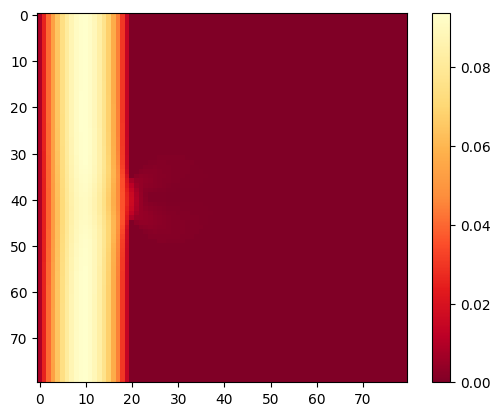

6000 142.4001762866974 2.000178005303035


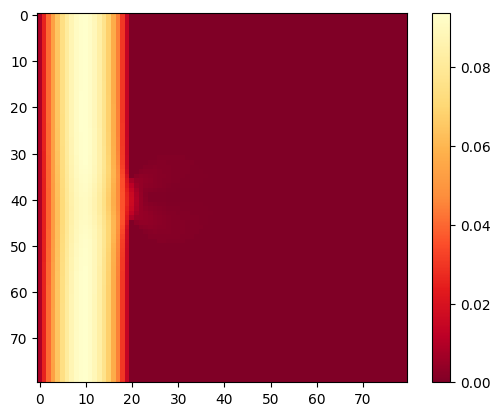

6500 154.77359795570374 2.000178005303035


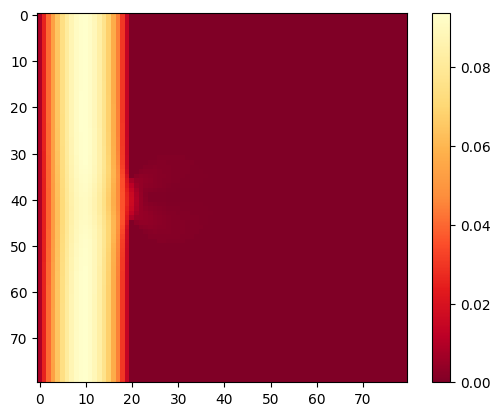

7000 167.09638833999634 2.000178005303035


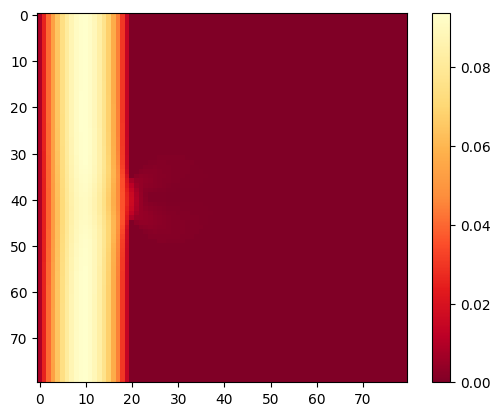

7500 179.135098695755 2.000178005303035


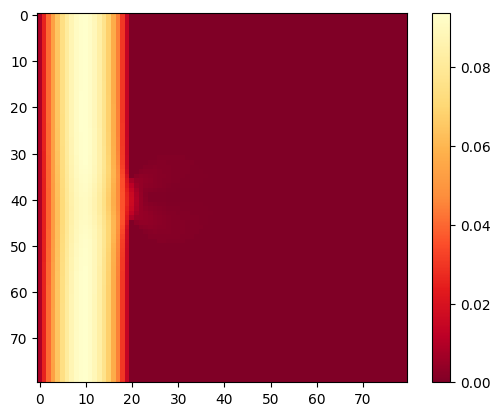

8000 189.61951279640198 2.000178005303035


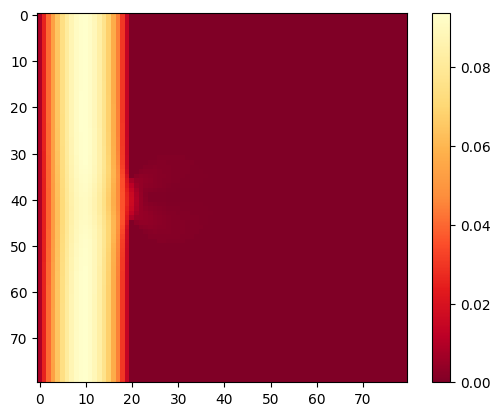

8500 202.02529668807983 2.000178005303035


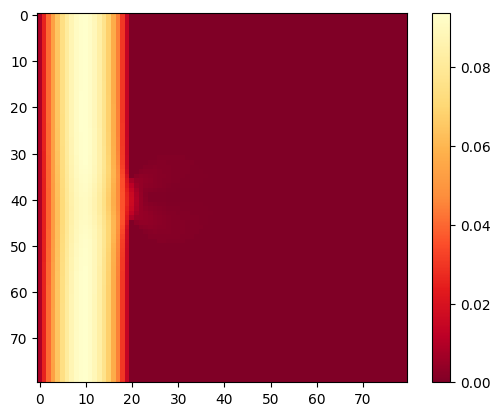

9000 214.34554958343506 2.000178005303035


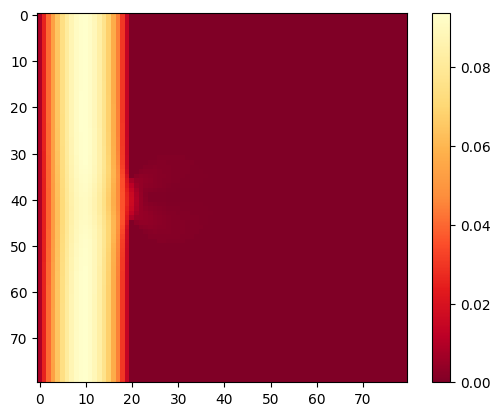

9500 227.2148666381836 2.000178005303035


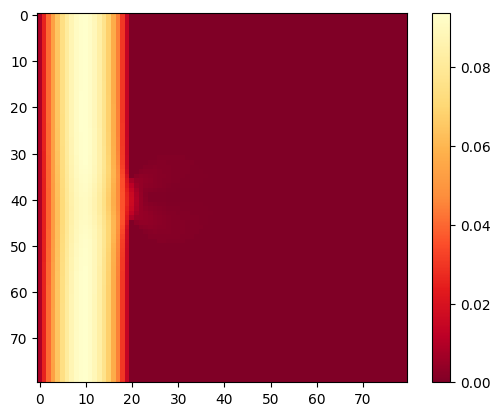

10000 2.0000000000375233 0.5555555555555556 0.052179064875553356


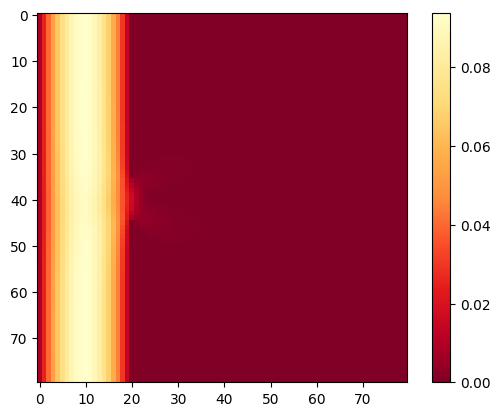

In [6]:
# modifying LBM for porous media - aneurysm as porous medium

import numpy as np
import time
import matplotlib.pyplot as plt

start = time.time()

# Simulation parameters

tau = 0.8
omega = 1/tau
cssq = 1/3
nu = cssq*(tau - 0.5)

tol = 1e-6
relerror = 1

eps = 0.1*np.ones((nx, ny))
Da = 1e-6*np.ones((nx, ny))
for i in inner_points:
    if i[1] > L:
        eps[i[0], i[1]] = 0.5
        Da[i[0], i[1]] = 1e-3
    else:
        eps[i[0], i[1]] = 1
        Da[i[0], i[1]] = 1e6

Re = 450
H = ny + 1
u0 = Re*nu/H
K = Da*H**2

Feps = 1.75/(150*eps**3)**0.5

a = 1/cssq
b = 1/(eps*cssq)
c = 1/(eps*cssq**2)

c0 = 0.5*(1 + eps*0.5*nu/K)

c1 = eps*0.5*Feps/(K**0.5)


# D2Q9 lattice arrangement
ndir = 9
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])
k_ = np.array([0, 2, 1, 4, 3, 7, 8, 5, 6])

# Simulation initialisation
rho = np.ones((nx, ny))

ux = np.zeros((nx, ny))
uy = np.zeros((nx, ny))
uxold = np.zeros((nx, ny))
uyold = np.zeros((nx, ny))
feq = np.zeros((ndir, nx, ny))
Fdist = np.zeros((ndir,nx,ny))

Gx = 1e-4
Fx = eps*Gx

for k in range(ndir):
    feq[k, :, :] = w[k]
    dotprodF = cx[k]*Fx
    Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*dotprodF*a

f = np.copy(feq)
fold = np.copy(feq)

t = 0

print('Starting simulation')

# Simulation loop
while t<10000:

    # Collision
    f = (1 - omega)*fold + omega*feq + Fdist

    # Streaming - Explicit version
    # automatically applies periodic boundary conditions in all edges of computation domain
    for k in range(ndir):
      fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

    # Boundary conditions
    # No-slip boundary condition on the bottom and top walls (in the y-axis)
    # Implemented by half-way bounce-back
    fold[3, :, 0] = f[4, :, 0]
    fold[5, :, 0] = f[7, :, 0]
    fold[6, :, 0] = f[8, :, 0]

    fold[4, :, ny - 1] = f[3, :, ny - 1]
    fold[7, :, ny - 1] = f[5, :, ny - 1]
    fold[8, :, ny - 1] = f[6, :, ny - 1]

    # Implementing bounce-back on aneurysm geometry
    for k in range(ndir):
        for i in range(nx):
            for j in range(ny):
                if mask[i,j] == 1:
                    fold[k, i, j] = f[k_[k], i, j]

    # Macroscopic variables: density, velocity, forces
    rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]

    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))

    for k in range(ndir):
        vx += cx[k]*fold[k, :, :]
        vy += cy[k]*fold[k, :, :]


    vx = vx/rho + 0.5*eps*Gx
    vy /= rho
    vmagn = (vx**2 + vy**2)**0.5

    ux = vx / (c0 + (c0**2 + c1*vmagn)**0.5)
    uy = vy / (c0 + (c0**2 + c1*vmagn)**0.5)
    umagn = (ux**2 + uy**2)**0.5


    Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
    Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

    # Equilibrium distribution function (+ force term)
    for k in range(ndir):
        dotprod = cx[k]*ux + cy[k]*uy
        udotu = ux**2 + uy**2
        dotprodF = cx[k]*Fx + cy[k]*Fy
        udotF = ux*Fx + uy*Fy
        feq[k, :, :] = w[k]*rho*(1 + dotprod*a + dotprod**2*0.5*c - udotu*0.5*b)
        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF*a + dotprod*dotprodF*c - udotF*b)

    # Computing relative error
    num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5
    relerror = np.max(num/umagn)

    uxold = ux
    uyold = uy

    if t>5000 and  t%500==0:
        print(t, time.time()-start, relerror)
        plt.imshow(umagn/u0)
        plt.colorbar()
        plt.show()

    t += 1


print(t, relerror, u0, np.max(ux))

umagn = np.sqrt(ux**2 + uy**2)
for i in inner_points:
    if inner_mask[i[0], i[1]] == 0:
        umagn[i[0], i[1]] = np.nan
plt.imshow(umagn/u0)
plt.colorbar()
plt.show()


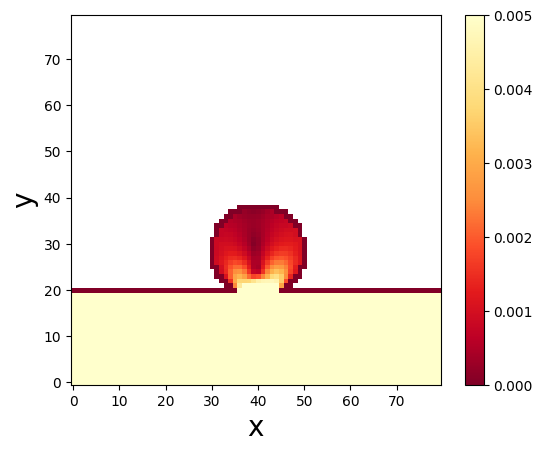

In [7]:
# post processing

umagn = np.sqrt(ux**2 + uy**2)

for i in range(nx):
    for j in range(ny):
        if inner_mask[i, j] == 0:
            umagn[i, j] = np.inf

umax = 0
for i in inner_points:
    if umagn[i[0], i[1]] > umax:
        umax = umagn[i[0], i[1]]


umagn = np.transpose(umagn)

# plt.imshow(umagn/u0, origin='lower')
# plt.ylabel('y', fontsize = 20)
# plt.xlabel('x', fontsize = 20)
# plt.colorbar()
# # plt.show()
# tikzplotlib.save('porous0.5.tex')

plt.imshow(umagn/u0, origin='lower')
plt.ylabel('y', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.clim(0, 0.005)
plt.colorbar()
plt.show()